In [1]:
import numpy as np
from scipy.optimize import curve_fit
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os
import pandas as pd
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [12,10]
plt.rcParams['font.size'] = 14

In [2]:
def step_plot(x, y, binwidth):
        xsteps = []
        ysteps = []
        for i in range(len(x)):
            xsteps.append(x[i] - binwidth/2)
            xsteps.append(x[i] + binwidth/2)
            ysteps.append(y[i])
            ysteps.append(y[i])
        return xsteps, ysteps

In [3]:
def quickpos(x, y, x0, y0, size, binsize=1.0, doplot=False):

    quickpos_fig, ax = plt.subplots(3, 1)

    if doplot:
        ax[0].scatter(x, y, s=0.5, c='k')
        ax[0].set_xlim(x0 - size, x0 + size)
        ax[0].set_ylim(y0 - size, y0 + size)
        ax[0].set_title('Centroid Plot')

    ob = np.where((np.abs(x-x0) < size) & (np.abs(y-y0) < size))

#define bin edges for x and y
    xbins = np.arange(x0 - size, x0 + size + binsize, binsize)
    ybins = np.arange(y0 - size, y0 + size + binsize, binsize)

#creating histograms for x and y
    xhist, xedges = np.histogram(x[ob], bins=xbins)
    yhist, yedges = np.histogram(y[ob], bins=ybins)

#define bin centers for x and y
    xval = 0.5*(xedges[:-1] + xedges[1:])
    yval = 0.5*(yedges[:-1] + yedges[1:])

    def gaussian(x, a, mu, sigma, offset):
        return a * np.exp(-((x - mu)**2) / (2 * sigma**2)) + offset

#fitting gaussian to x and y histograms and plotting each one
    xmax = np.max(xhist)
    x0_new = xval[np.argmax(xhist)]
    xestpar = [xmax, x0_new, 2*binsize, 0]
    xpar = xestpar

    xpar, _ = curve_fit(gaussian, xval, xhist, p0=xestpar)
    xf = gaussian(xval, *xpar)

    if doplot:
        xval_s, xhist_s = step_plot(xval, xhist, binsize)
        ax[1].plot(xval_s, xhist_s, c='b', alpha=0.3, label='xhist')
        ax[1].plot(xval, xf, '--', c='red', linewidth=0.75)
        ax[1].legend()

    ymax = np.max(yhist)
    y0_new = yval[np.argmax(yhist)]
    yestpar = [ymax, y0, 2*binsize, 0]
    ypar = yestpar

    ypar, _ = curve_fit(gaussian, yval, yhist, p0=yestpar)
    yf = gaussian(yval, *ypar)

    if doplot:
        yval_s, yhist_s = step_plot(yval, yhist, binsize)
        #ax.bar(xval, xhist, width=binsize, color='blue', alpha=0.3, label='Histogram')
        ax[2].plot(yval_s, yhist_s, c='b', alpha=0.3, label='yhist')
        ax[2].plot(yval, yf, '--', c='red', linewidth=0.75)
        ax[2].legend()

#estimating total counts and returning source position
    xcnt = xpar[0] * xpar[2] * np.sqrt(2*np.pi) * binsize
    ycnt = ypar[0] * ypar[2] * np.sqrt(2*np.pi) * binsize
    cnt = 0.5 * (xcnt + ycnt)

    #print('Widths:', xpar[2], ypar[2])
    xsrc = xpar[1]
    ysrc = ypar[1]
    
    return xsrc, ysrc, cnt, quickpos_fig

In [4]:
def process_one_hrc(infile, r_in, r_out, angle_bin, doplot=False):

    def iterative_quickpos(x, y, x0, y0, iterations, size_list, binsize_list, doplot=True):
        """
        Iteratively run quickpos.
        
        Parameters:
          x, y: data arrays
          x0, y0: initial centroid estimates
          iterations: number of iterations to perform
          size_list: list of size values for each iteration
          binsize_list: list of binsize values for each iteration
          doplot: whether to generate the plot
        
        Returns:
          final_x, final_y: final estimated centroid positions
          final_cnt: final counts estimate
          fig_list: list of figures from each iteration
        """
        fig_list = []
        current_x0, current_y0 = x0, y0
        final_cnt = None
        for i in range(iterations):
            size = size_list[i]
            binsize = binsize_list[i]
            current_x0, current_y0, cnt, fig = quickpos(x, y, current_x0, current_y0, size, binsize, doplot)
            fig_list.append(fig)
            final_cnt = cnt
        return current_x0, current_y0, final_cnt, fig_list

    obs_name = infile.split('/')[5]
    obs = fits.open(infile)
    hdr = obs[1].header
    d = obs[1].data

#extracting scale and reference coordinate    
    scale = hdr['tcdlt20']
    xc = hdr['tcrpx20']
    exptime = hdr['exposure']
    
#form modified julian date for this obs
    mjd_start = hdr['mjd-obs']
    half_expos = 0.5 * (hdr['tstop']-hdr['tstart'])
    date = mjd_start + half_expos / 86400

#converting event positions to arcsec
    x = (d['x'] - xc) * scale * 3600
    y = (d['y'] - xc) * scale * 3600

    rr = np.sqrt(x**2 + y**2)
    ok = np.where(rr < 20)
    
    if doplot:
        data_fig, ax = plt.subplots()
        ax.plot(x[ok], y[ok], 'ko', ms=1, mew=0)
        ax.set_title(obs_name)
        ax.set_xlabel('X (arcsec)')
        ax.set_ylabel('Y (arcsec)')

#starting estimate of centroid    
    x0_est = np.average(x[ok])
    y0_est = np.average(y[ok])

#three rounds of quickpos to better estimate core position
    iterations = 3
    size_list = [10, 5, 1.5]
    binsize_list = [0.1, 0.1, 0.05]

    x0_best, y0_best, cnt, qp_figs = iterative_quickpos(x[ok], y[ok], x0_est, y0_est, iterations, size_list, binsize_list)
    
    #xsrc, ysrc, cnt, quickpos_fig = quickpos(x[ok], y[ok], x0_est, y0_est, size=10, binsize=0.1, doplot=True)
    #x0_better, y0_better, cnt, quickpos_fig = quickpos(x[ok], y[ok], xsrc, ysrc, size=5, binsize=0.1, doplot=True)
    #x0_best, y0_best, cnt, quickpos_fig = quickpos(x[ok], y[ok], x0_better, y0_better, size=1.5, binsize=0.05, doplot=True)

    dx = x[ok] - x0_best
    dy = y[ok] - y0_best

    if doplot:
        centroid_fig, ax = plt.subplots()
        ax.scatter(dx, dy, s=0.1, c='k')
        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        ax.set_xlabel('X (arcsec)')
        ax.set_ylabel('Y (arcsec)')
        ax.set_title(obs_name + ' after 3 rounds of quickpos')

#radius and azimuth of each event
    rr = np.sqrt(dx**2 + dy**2)
    theta1 = -np.degrees(np.arctan2(dx, dy))

    cnt_core = np.sum(rr <= r_in)

    okhist = np.where((rr > r_in) & (rr <= r_out))
    bins = np.linspace(-180, 180, int(360/angle_bin) + 1)
    thist0, bin_edges = np.histogram(theta1[okhist], bins=bins)
    tval0 = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    #xs, ys = step_plot(tval0, thist0, bin_width)
    #plt.plot(xs, ys, c='red')
    #plt.xlabel('Position Angle (deg)')
    #plt.title(obs_name + ' radii and azi (process_one)')
    #plt.show()

#fitting two gaussians and bg
    xx = tval0
    yy = thist0
    weight = 1 / yy
    nx = len(xx)
    a0est = np.max(yy[xx > 0])
    a3est = np.max(yy[xx < 0])
    center_ind = np.arange(nx//2-2, nx//2+3)
    bg_est = np.average(yy[center_ind])
    sig_est = 20
    coeff_est = [a0est, 90, sig_est, a3est, -90, sig_est, bg_est]
    coeff = coeff_est

    def gaussian2(x, a1, mu1, sigma1, a2, mu2, sigma2, bg):
        return (a1 * np.exp(-((x - mu1)**2) / (2*sigma1**2)) + a2 * np.exp(-((x - mu2)**2) / (2*sigma2**2)) + bg)

    popt, pcov = curve_fit(gaussian2, xx, yy, p0=coeff_est, sigma=1/weight)
    yfit = gaussian2(xx, *popt)
    sigma = np.sqrt(np.diag(pcov))
    
    if doplot:
        xs, ys = step_plot(xx, yy, bin_width)
        twogauss_fig, ax = plt.subplots()
        ax.plot(xs, ys, c='blue', alpha=0.3)
        ax.plot(xx, yfit, c='red', ls='--')
        ax.set_xlabel('Position Angle (deg)')
        ax.set_title(obs_name)

    #print('Fitted Coefficients:', popt)
    #print('Parameter Uncertanties', sigma)
    params = popt
    
    return params, sigma, date, exptime, cnt_core, data_fig, qp_figs, centroid_fig, twogauss_fig

In [5]:
files = sorted(glob.glob('/Users/leodrake/Documents/MIT/ss433/HRC_2024/*/repro/*evt2_splinecorr.fits'))
#files = sorted(glob.glob('/Users/leo/LocalDocs/HRC_2024/*/primary/hrcf26568N001_evt2.fits'))
nfile = len(files)

dates = np.zeros(nfile, dtype=float)
exptimes = np.zeros(nfile, dtype=float)
core_counts = np.zeros(nfile, dtype=float)
bg_counts = np.zeros(nfile, dtype=float)
bg_counts_err = np.zeros(nfile, dtype=float)
norms = np.zeros((nfile, 2), dtype=float)
norms_err = np.zeros((nfile, 2), dtype=float)
positions = np.zeros((nfile, 2), dtype=float)
positions_err = np.zeros((nfile, 2), dtype=float)
gauss_sigmas = np.zeros((nfile, 2), dtype=float)
gauss_sigmas_err = np.zeros((nfile, 2), dtype=float)

r_in  = 0.7 #arcseconds
r_out = 5
angle_bin = 4 #degrees
bgcorr = 360 / angle_bin

with PdfPages('ss433-hrc-python.pdf') as pdf:
    for i, filename in enumerate(files):
        params, sigma, date_obs, exposure, cnt_core, data_fig, qp_figs, centroid_fig, twogauss_fig= process_one_hrc(filename, r_in, r_out, angle_bin, doplot=True)
    
        dates[i] = date_obs
        exptimes[i] = exposure
        core_counts[i] = cnt_core
    
        norms[i, 0] = params[0]
        norms[i, 1] = params[3]
        norms_err[i, 0] = sigma[0]
        norms_err[i, 1] = sigma[3]
    
        positions[i, 0] = params[1]
        positions[i, 1] = params[4]
        positions_err[i, 0] = sigma[1]
        positions_err[i, 1] = sigma[4]
    
        gauss_sigmas[i, 0] = params[2]
        gauss_sigmas[i, 1] = params[5]
        gauss_sigmas_err[i, 0] = sigma[2]
        gauss_sigmas_err[i, 1] = sigma[5]
    
        bg_counts[i] = bgcorr * params[6]
        bg_counts_err[i] = bgcorr * sigma[6]
    
        pdf.savefig(data_fig)
        for qp_fig in qp_figs:
            pdf.savefig(qp_fig)
        pdf.savefig(centroid_fig)
        pdf.savefig(twogauss_fig)
    
        plt.close(data_fig)
        for qp_fig in qp_figs:
            plt.close(qp_fig)
        plt.close(centroid_fig)
        plt.close(twogauss_fig)
     
     

#estimate counts in the extended regions

counts = np.sqrt(2* np.pi) * gauss_sigmas * norms / angle_bin
counts_err = counts * (norms_err / norms)
core_counts_corr = core_counts + bg_counts

In [6]:
# 1) Calculate lobe 1 counts
cts_lobe1 = norms[:,0] * np.sqrt(2*np.pi) * gauss_sigmas[:,0]
cts_lobe1_err = cts_lobe1 * np.sqrt((norms_err[:,0]/norms[:,0])**2 + (gauss_sigmas_err[:,0]/gauss_sigmas[:,0])**2)

# 2) Calculate lobe 2 counts
cts_lobe2 = norms[:,1] * np.sqrt(2*np.pi) * gauss_sigmas[:,1]
cts_lobe2_err = cts_lobe2 * np.sqrt((norms_err[:,1]/norms[:,1])**2 + (gauss_sigmas_err[:,1]/gauss_sigmas[:,1])**2)

# 4) Count rates (assuming 'exposure' is your exposure time)
ctrate_lobe1 = cts_lobe1 / exptimes
ctrate_lobe1_err = cts_lobe1_err / exptimes
ctrate_lobe2 = cts_lobe2 / exptimes
ctrate_lobe2_err = cts_lobe2_err / exptimes

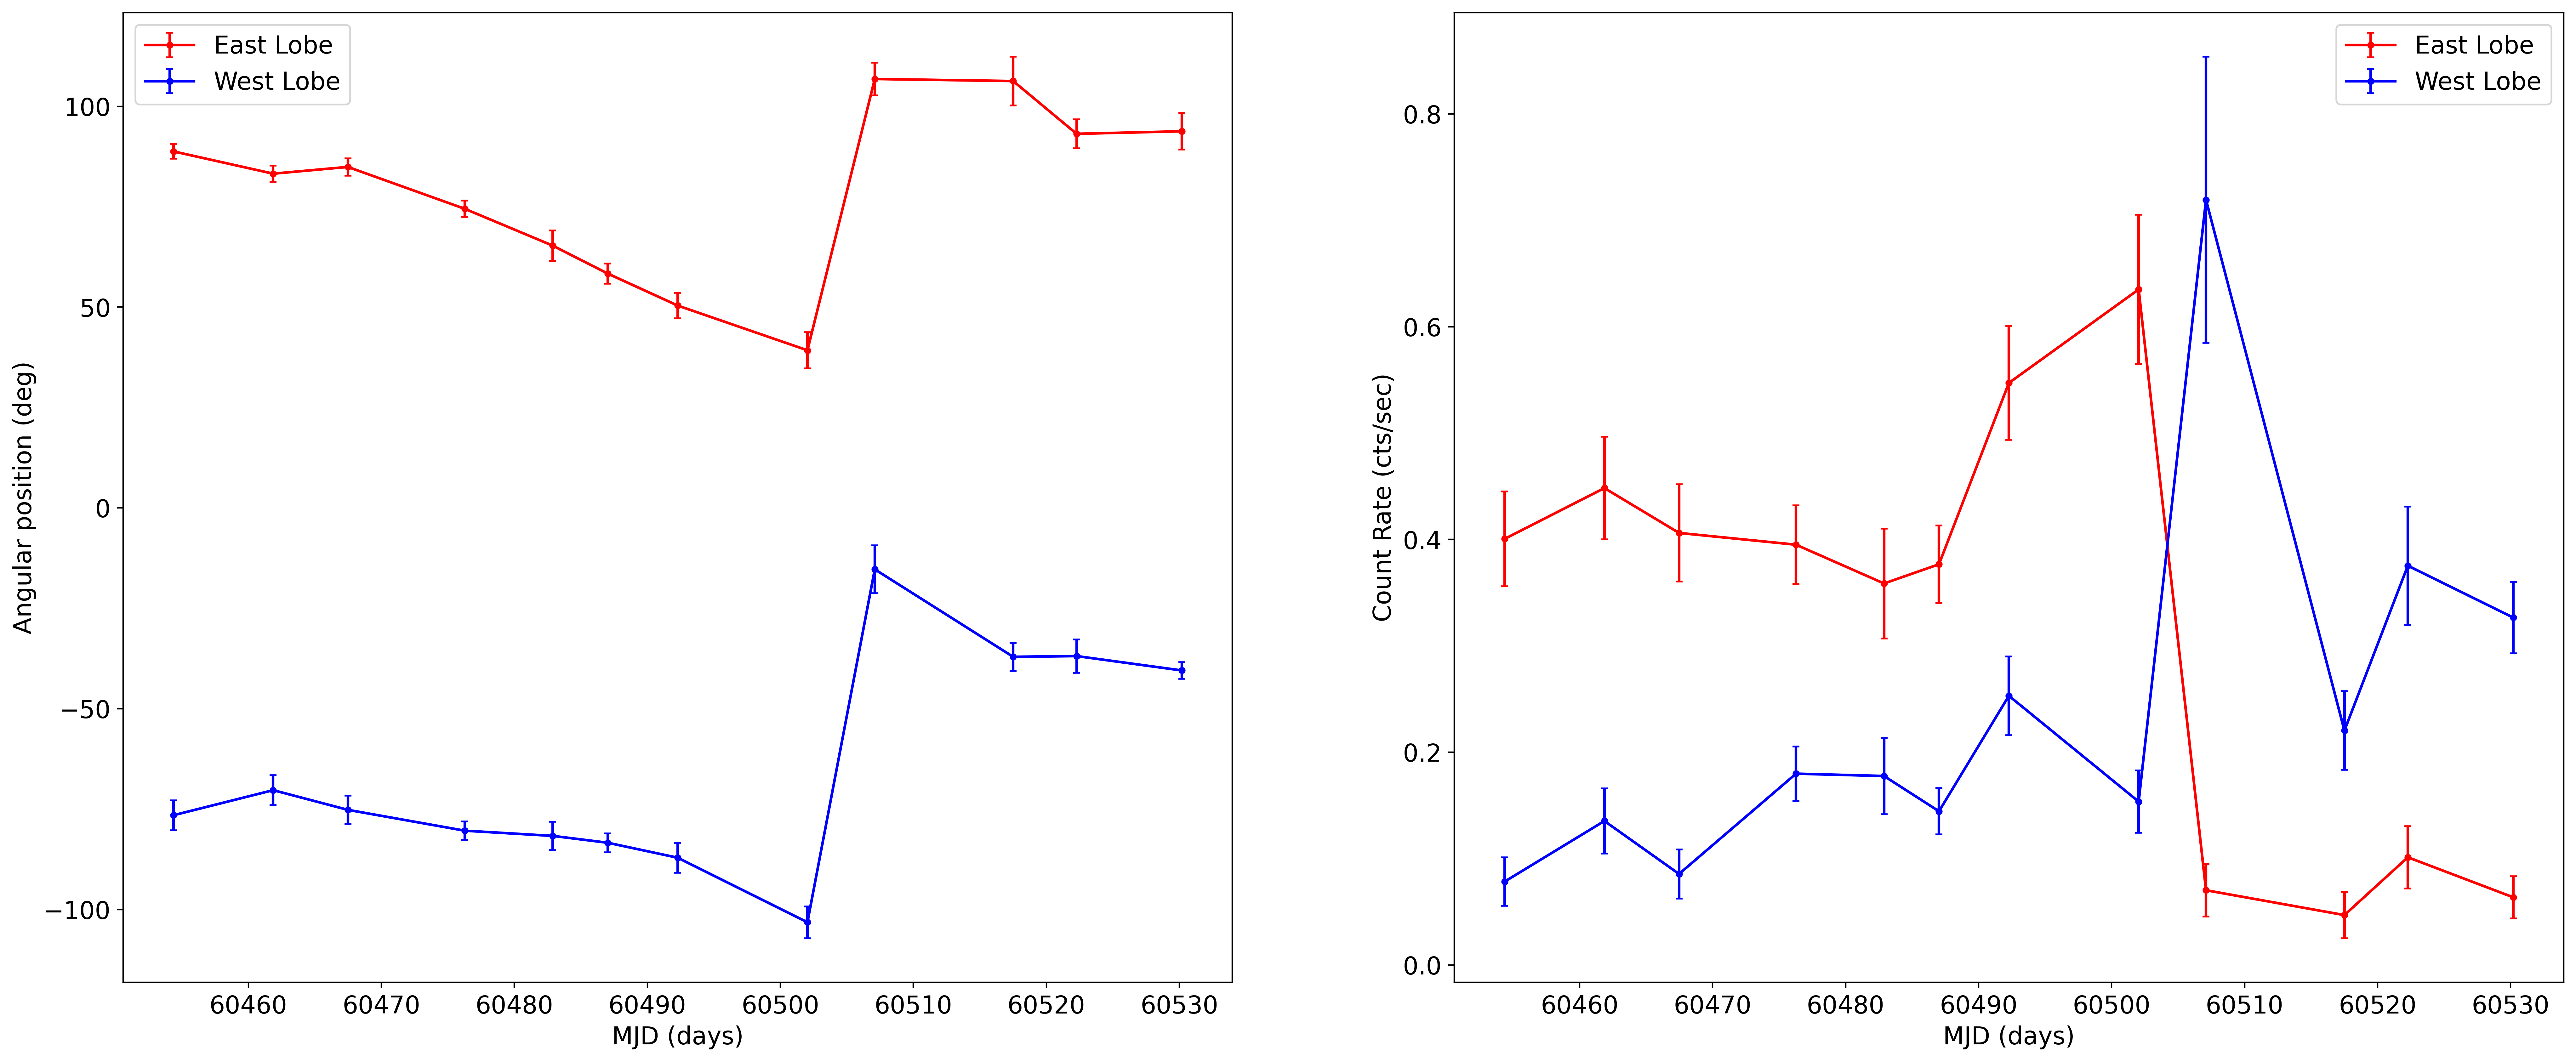

In [7]:
timeplots, (pos, ctrt) = plt.subplots(1,2, figsize=(25,10))
pos.errorbar(dates, positions[:,0], positions_err[:,0], c='r', fmt='.-', capsize=2, label='East Lobe')
pos.errorbar(dates, positions[:,1], positions_err[:,1], c='b', fmt='.-', capsize=2, label='West Lobe')
pos.set_xlabel('MJD (days)')
pos.set_ylabel('Angular position (deg)')
pos.legend()
ctrt.errorbar(dates, ctrate_lobe1, ctrate_lobe1_err, c='r', fmt='.-', capsize=2, label='East Lobe')
ctrt.errorbar(dates, ctrate_lobe2, ctrate_lobe2_err, c='b', fmt='.-', capsize=2, label='West Lobe')
ctrt.set_xlabel('MJD (days)')
ctrt.set_ylabel('Count Rate (cts/sec)')
ctrt.legend()
plt.show()

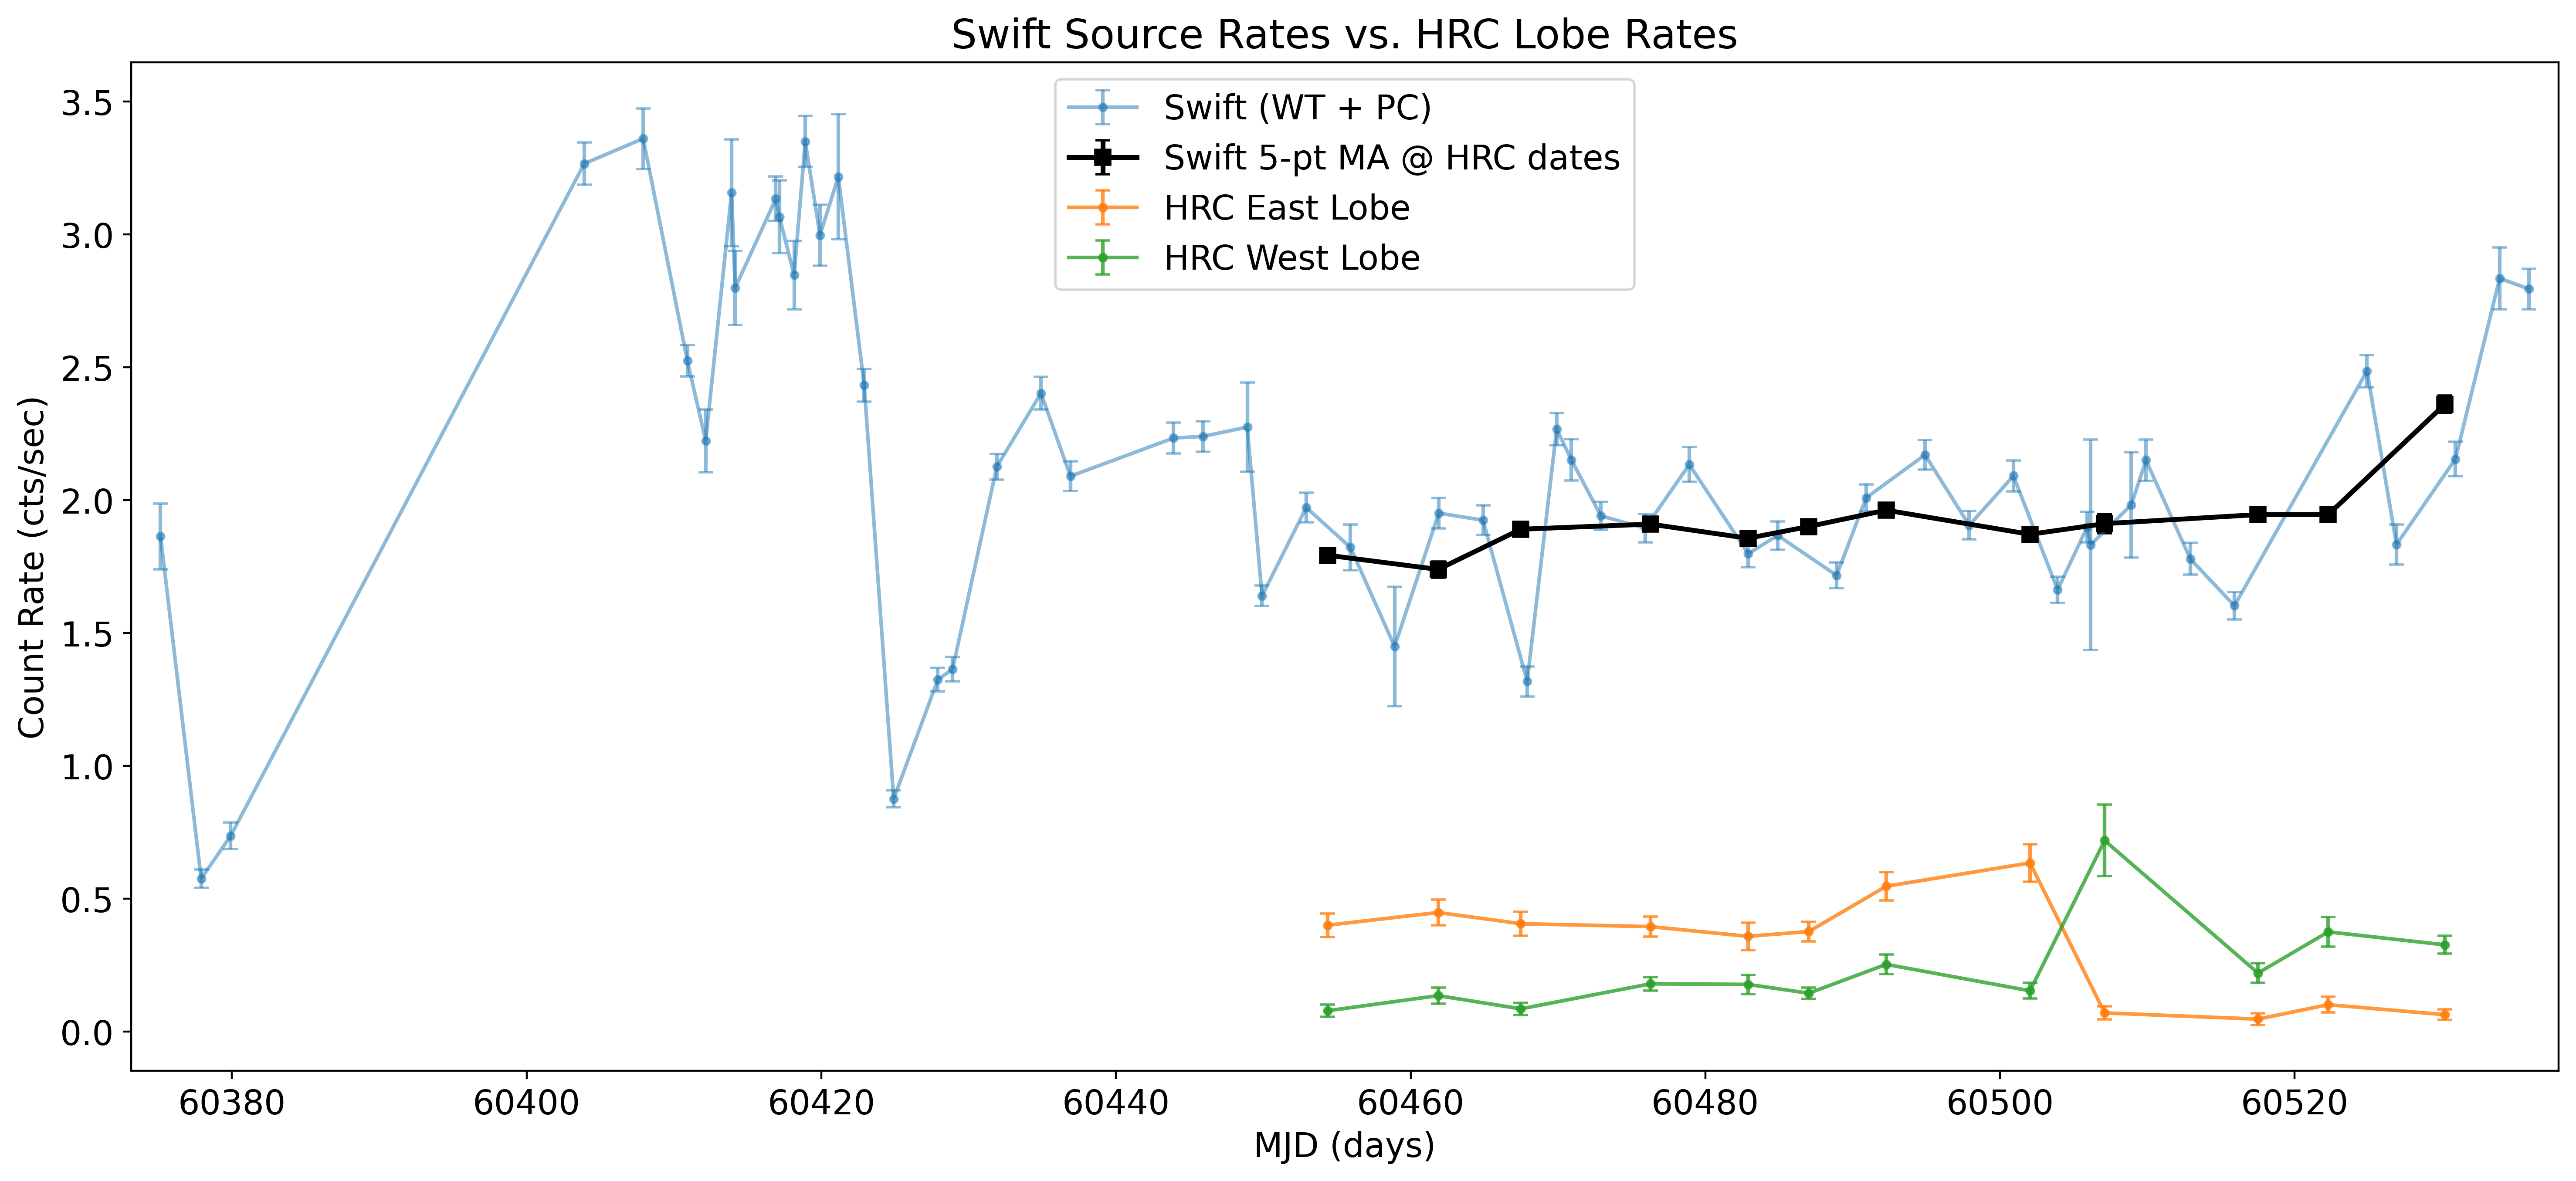

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- (1) Your HRC‐fits data, computed earlier in your notebook/script ---
# let's assume you already have:
#   dates  <- the MJD array for your HRC observations
#   ctrate_lobe1, ctrate_lobe1_err
#   ctrate_lobe2, ctrate_lobe2_err
hrc_dates = dates.copy()

# --- (2) Load *all* Swift data (WT + PC) into its own variables ---
swift_file = "/Users/leodrake/Documents/MIT/ss433/swift-hrc-data.txt"
swift_list = []
with open(swift_file, "r") as f:
    for line in f:
        line = line.strip()
        # skip comments or sentinel lines
        if not line or line[0] in ("!", "N"):
            continue
        tok = line.split()
        if len(tok) < 6:
            continue
        try:
            mjd = float(tok[0])
        except ValueError:
            continue
        rate     = float(tok[3])
        err_low  = abs(float(tok[4]))
        err_high = abs(float(tok[5]))
        swift_list.append((mjd, rate, 0.5*(err_low+err_high)))

# convert to array and sort by MJD
swift_arr    = np.array(swift_list)
order        = np.argsort(swift_arr[:,0])
swift_arr    = swift_arr[order]

swift_dates  = swift_arr[:,0]
swift_rate   = swift_arr[:,1]
swift_err    = swift_arr[:,2]

# --- (3) Compute Swift moving average evaluated at each HRC date ---
window_size = 5
half_w = window_size // 2

swift_ma     = np.zeros_like(hrc_dates)
swift_ma_err = np.zeros_like(hrc_dates)

for i, t in enumerate(hrc_dates):
    idx = np.searchsorted(swift_dates, t)
    start = max(0, idx - half_w)
    end   = min(len(swift_dates), idx + half_w + 1)
    rates = swift_rate[start:end]
    errs  = swift_err[start:end]
    w = 1.0 / errs**2
    swift_ma[i]     = np.sum(rates * w) / np.sum(w)
    swift_ma_err[i] = 1.0 / np.sqrt(np.sum(w))

# --- (4) Plot Swift + HRC lobe rates + Swift MA@HRC-times ---
plt.figure(figsize=(15,7))

# Swift raw whole‐source (WT + PC)
plt.errorbar(
    swift_dates, swift_rate, yerr=swift_err,
    fmt='.-', capsize=3, alpha=0.5,
    label='Swift (WT + PC)'
)

# Swift MA at HRC dates
plt.errorbar(
    hrc_dates, swift_ma, yerr=swift_ma_err,
    fmt='s-', color='k', capsize=3, lw=2,
    label=f'Swift {window_size}-pt MA @ HRC dates'
)

# HRC East lobe
plt.errorbar(
    hrc_dates, ctrate_lobe1, yerr=ctrate_lobe1_err,
    fmt='.-', color='C1', capsize=3, alpha=0.8,
    label='HRC East Lobe'
)

# HRC West lobe
plt.errorbar(
    hrc_dates, ctrate_lobe2, yerr=ctrate_lobe2_err,
    fmt='.-', color='C2', capsize=3, alpha=0.8,
    label='HRC West Lobe'
)

plt.xlabel("MJD (days)")
plt.ylabel("Count Rate (cts/sec)")
plt.title("Swift Source Rates vs. HRC Lobe Rates")
plt.legend()
plt.xlim(swift_dates.min() - 2, swift_dates.max() + 2)
plt.tight_layout()
plt.show()